In [1]:
# packages
import pandas as pd
import numpy as np
from nba_api.stats.static import players
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from yellowbrick.features import Rank2D
from yellowbrick.classifier import ConfusionMatrix


In [2]:
df = pd.read_csv('nba_player_dataset.csv')
df.describe()

,PLAYER_ID,LEAGUE_ID,TEAM_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,TRADE_SEASON
count,2.847500e+04,28475.0,2.847500e+04,28475.000000,28475.000000,21993.000000,27706.000000,28475.000000,28475.000000,28461.000000,...,24312.000000,24312.000000,27818.000000,28475.000000,24312.000000,24312.000000,23160.000000,28475.000000,28475.000000,28475.000000
mean,1.910828e+05,0.0,1.473619e+09,27.045724,49.365654,22.917428,1163.322710,188.724109,417.496822,0.427675,...,58.590655,144.323626,216.124955,110.821387,38.235480,23.512298,70.282988,110.944021,494.931835,0.175944
std,4.201317e+05,0.0,4.493150e+08,4.170652,26.503202,28.152090,929.837939,184.376258,390.551268,0.104665,...,65.387191,143.939275,223.114425,132.956215,37.572835,35.407875,66.358784,83.244617,484.922546,0.380779
min,2.000000e+00,0.0,0.000000e+00,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.737000e+03,0.0,1.610613e+09,24.000000,26.000000,0.000000,305.000000,38.000000,93.000000,0.389000,...,11.000000,32.000000,47.000000,18.000000,8.000000,3.000000,16.000000,35.000000,100.000000,0.000000
50%,7.696000e+04,0.0,1.610613e+09,26.000000,55.000000,8.000000,995.000000,134.000000,306.000000,0.438000,...,35.000000,104.000000,152.000000,64.000000,28.000000,11.000000,51.000000,101.000000,349.000000,0.000000
75%,1.012535e+05,0.0,1.610613e+09,30.000000,74.000000,43.000000,1898.000000,287.000000,640.000000,0.480000,...,84.000000,209.000000,308.000000,154.000000,57.000000,28.000000,107.000000,174.000000,755.500000,0.000000
max,1.630698e+06,0.0,1.610613e+09,94.000000,88.000000,83.000000,3882.000000,1597.000000,3159.000000,1.000000,...,587.000000,1111.000000,2149.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,4029.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28475 entries, 0 to 28474
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLAYER_ID          28475 non-null  int64  
 1   SEASON_ID          28475 non-null  object 
 2   LEAGUE_ID          28475 non-null  int64  
 3   TEAM_ID            28475 non-null  int64  
 4   TEAM_ABBREVIATION  28466 non-null  object 
 5   PLAYER_AGE         28475 non-null  int64  
 6   GP                 28475 non-null  int64  
 7   GS                 21993 non-null  float64
 8   MIN                27706 non-null  float64
 9   FGM                28475 non-null  int64  
 10  FGA                28475 non-null  int64  
 11  FG_PCT             28461 non-null  float64
 12  FG3M               22442 non-null  float64
 13  FG3A               22442 non-null  float64
 14  FG3_PCT            22220 non-null  float64
 15  FTM                28475 non-null  int64  
 16  FTA                284

In [4]:
player_list = players.get_players()
keys = player_list[0].keys()
with open("player_list.csv", 'w', newline='') as file:
    csvwriter = csv.DictWriter(file, keys)
    csvwriter.writeheader()
    csvwriter.writerows(player_list)

In [5]:
# Add a year column to coincide with the all star season year
def all_star_year_apply(string):
    if string[0:4] == '1999':
        return 2000
    else:
        return int(string[0:3]+string[-1])

df['ALL_STAR_SEASON_YEAR'] = df['SEASON_ID'].apply(all_star_year_apply)
# df['ALL_STAR_YEAR']


In [6]:
# add player_list columns to the nba_player_dataset

player_list_df = pd.read_csv('player_list.csv')

df = pd.merge(df, player_list_df,how='left', left_on='PLAYER_ID', right_on='id')
df.head(7)

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,TOV,PF,PTS,TRADE_SEASON,ALL_STAR_SEASON_YEAR,id,full_name,first_name,last_name,is_active
0,76001,1990-91,0,1610612757,POR,23,43,0.0,290.0,55,...,22.0,39,135,0,1991,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False
1,76001,1991-92,0,1610612757,POR,24,71,1.0,934.0,178,...,66.0,132,432,0,1992,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False
2,76001,1992-93,0,1610612749,MIL,25,12,0.0,159.0,26,...,13.0,24,64,1,1993,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False
3,76001,1992-93,0,1610612738,BOS,25,63,52.0,1152.0,219,...,84.0,165,514,1,1993,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False
4,76001,1992-93,0,0,TOT,25,75,52.0,1311.0,245,...,97.0,189,578,0,1993,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False
5,76001,1993-94,0,1610612738,BOS,26,13,0.0,159.0,24,...,17.0,20,64,0,1994,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False
6,76001,1994-95,0,1610612758,SAC,27,51,0.0,476.0,117,...,40.0,102,254,1,1995,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False


In [7]:
nba_all_star_df = pd.read_csv('nba_all_star_selections.csv')

df = pd.merge(df, nba_all_star_df, how='left', left_on=['ALL_STAR_SEASON_YEAR', 'full_name'], right_on=['ALL_STAR_GAME_YEAR', 'PLAYER'])
df.head(7)

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,id,full_name,first_name,last_name,is_active,ALL_STAR_GAME_YEAR,PLAYER,TEAM,FIRST_NAME,LAST_NAME
0,76001,1990-91,0,1610612757,POR,23,43,0.0,290.0,55,...,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False,NaN,NaN,NaN,NaN,NaN
1,76001,1991-92,0,1610612757,POR,24,71,1.0,934.0,178,...,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False,NaN,NaN,NaN,NaN,NaN
2,76001,1992-93,0,1610612749,MIL,25,12,0.0,159.0,26,...,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False,NaN,NaN,NaN,NaN,NaN
3,76001,1992-93,0,1610612738,BOS,25,63,52.0,1152.0,219,...,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False,NaN,NaN,NaN,NaN,NaN
4,76001,1992-93,0,0,TOT,25,75,52.0,1311.0,245,...,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False,NaN,NaN,NaN,NaN,NaN
5,76001,1993-94,0,1610612738,BOS,26,13,0.0,159.0,24,...,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False,NaN,NaN,NaN,NaN,NaN
6,76001,1994-95,0,1610612758,SAC,27,51,0.0,476.0,117,...,76001,Alaa Abdelnaby,Alaa,Abdelnaby,False,NaN,NaN,NaN,NaN,NaN


In [8]:
# filter df to contain only 2000 - 2019 all star seasons.
print(df.shape)
df = df[(df['ALL_STAR_SEASON_YEAR']>= 2000) & (df['ALL_STAR_SEASON_YEAR'] <= 2019)]
df.shape

(28475, 39)


(12227, 39)

In [9]:
# Getting a sample set to see what columns can be dropped from the data frame
df.sample(7)

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,id,full_name,first_name,last_name,is_active,ALL_STAR_GAME_YEAR,PLAYER,TEAM,FIRST_NAME,LAST_NAME
3896,201979,2013-14,0,1610612763,MEM,25,71,7.0,1173.0,142,...,201979,Nick Calathes,Nick,Calathes,False,NaN,NaN,NaN,NaN,NaN
21386,2557,2013-14,0,1610612749,MIL,33,36,12.0,763.0,84,...,2557,Luke Ridnour,Luke,Ridnour,False,NaN,NaN,NaN,NaN,NaN
10874,202351,2012-13,0,1610612750,MIN,26,4,0.0,31.0,2,...,202351,Lazar Hayward,Lazar,Hayward,False,NaN,NaN,NaN,NaN,NaN
27894,2000,1999-00,0,1610612741,CHI,26,25,1.0,508.0,61,...,2000,Dedric Willoughby,Dedric,Willoughby,False,NaN,NaN,NaN,NaN,NaN
5516,201159,2008-09,0,1610612763,MEM,21,7,0.0,44.0,7,...,201159,Javaris Crittenton,Javaris,Crittenton,False,NaN,NaN,NaN,NaN,NaN
20765,2038,2004-05,0,1610612757,POR,25,76,50.0,1857.0,199,...,2038,Joel Przybilla,Joel,Przybilla,False,NaN,NaN,NaN,NaN,NaN
12031,1628990,2019-20,0,1610612741,CHI,24,28,10.0,527.0,80,...,1628990,Chandler Hutchison,Chandler,Hutchison,True,NaN,NaN,NaN,NaN,NaN


In [10]:
# Will drop a few columns to help clean up the dataframe

columns_to_drop = ['LEAGUE_ID', 'id', 'PLAYER', 'TEAM', 'FIRST_NAME', 'LAST_NAME']

df = df.drop(columns=columns_to_drop)
df.sample(7)

,PLAYER_ID,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,TOV,PF,PTS,TRADE_SEASON,ALL_STAR_SEASON_YEAR,full_name,first_name,last_name,is_active,ALL_STAR_GAME_YEAR
26610,221,1999-00,1610612748,MIA,29,78,2.0,1615.0,215,419,...,100.0,165,565,0,2000,Clar. Weatherspoon,Clar.,Weatherspoon,False,NaN
21499,101194,2008-09,0,TOT,26,29,0.0,276.0,44,120,...,8.0,18,119,0,2009,Anthony Roberson,Anthony,Roberson,False,NaN
22890,201196,2017-18,1610612752,NYK,32,13,3.0,167.0,17,53,...,15.0,14,48,1,2018,Ramon Sessions,Ramon,Sessions,False,NaN
22000,147,2001-02,1610612754,IND,29,53,53.0,1937.0,387,871,...,105.0,148,982,1,2002,Jalen Rose,Jalen,Rose,False,NaN
19494,182,1999-00,0,TOT,31,62,11.0,1305.0,150,358,...,85.0,166,374,0,2000,Billy Owens,Billy,Owens,False,NaN
19160,1885,2009-10,1610612747,LAL,30,82,38.0,2585.0,342,739,...,150.0,227,882,0,2000,Lamar Odom,Lamar,Odom,False,NaN
19951,324,2001-02,1610612750,MIN,32,82,0.0,2060.0,288,684,...,76.0,137,737,0,2002,Anthony Peeler,Anthony,Peeler,False,NaN


In [11]:
# Make a flag for a player making the all star game (if 'ALL_STAR_GAME_YEAR' is not null, flag as 1)
df['ALL_STAR_SELECTION_FLAG'] = np.where(df['ALL_STAR_GAME_YEAR'].isnull(), 0,1)
df.sample(7)

,PLAYER_ID,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,PF,PTS,TRADE_SEASON,ALL_STAR_SEASON_YEAR,full_name,first_name,last_name,is_active,ALL_STAR_GAME_YEAR,ALL_STAR_SELECTION_FLAG
6509,2564,2010-11,1610612766,CHA,29,82,82.0,2778.0,381,774,...,190,924,0,2011,Boris Diaw,Boris,Diaw,False,NaN,0
6666,2413,2002-03,1610612764,WAS,24,42,3.0,647.0,104,271,...,54,270,0,2003,Juan Dixon,Juan,Dixon,False,NaN,0
6283,201986,2013-14,0,TOT,27,47,3.0,494.0,64,153,...,48,177,0,2014,Nando De Colo,Nando,De Colo,False,NaN,0
107,203112,2012-13,1610612761,TOR,22,29,0.0,342.0,42,75,...,53,116,0,2013,Quincy Acy,Quincy,Acy,False,NaN,0
25690,202685,2013-14,1610612761,TOR,22,81,81.0,2282.0,359,676,...,249,916,0,2014,Jonas Valanciunas,Jonas,Valanciunas,True,NaN,0
18658,203526,2019-20,1610612755,PHI,28,54,3.0,668.0,101,222,...,50,275,0,2010,Raul Neto,Raul,Neto,True,NaN,0
27557,101150,2005-06,1610612755,PHI,19,30,0.0,145.0,23,52,...,13,56,0,2006,Lou Williams,Lou,Williams,True,NaN,0


In [12]:
# filter the dataset to only contain players with at least 3 years of stats.

values = df['PLAYER_ID'].value_counts()
values[:20]

1737      27
1713      25
1889      25
2772      24
201147    23
2207      23
2400      23
2594      23
2037      22
2200      22
2199      21
1897      21
2734      21
2229      20
693       20
202397    20
1536      20
201145    20
1890      20
436       20
Name: PLAYER_ID, dtype: int64

In [13]:
'''
because of doing the value count, it has been noticed that players do not play for 27 years.  The reason for 1737 having 27 values is the dataset
contains full season stats for players who were traded mid-season (and the individual stats for the different teams that player played on).  These
individual stats need to be removed.
'''
df = df[df['TRADE_SEASON']==0]
df.shape

(9842, 34)

In [14]:
df = df.groupby('PLAYER_ID').filter(lambda x: len(x) > 2)
df.shape

(8699, 34)

In [15]:
df.sample(7)

,PLAYER_ID,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,PF,PTS,TRADE_SEASON,ALL_STAR_SEASON_YEAR,full_name,first_name,last_name,is_active,ALL_STAR_GAME_YEAR,ALL_STAR_SELECTION_FLAG
17273,1626175,2015-16,1610612738,BOS,21,16,0.0,57.0,8,22,...,5,21,0,2016,Jordan Mickey,Jordan,Mickey,False,NaN,0
3563,1761,2002-03,1610612755,PHI,26,75,5.0,1514.0,185,398,...,203,450,0,2003,Greg Buckner,Greg,Buckner,False,NaN,0
20235,1718,2001-02,1610612738,BOS,24,82,82.0,3299.0,707,1598,...,237,2144,0,2002,Paul Pierce,Paul,Pierce,False,2002.0,1
6984,201,2002-03,1610612757,POR,38,3,0.0,11.0,0,1,...,3,0,0,2003,Chris Dudley,Chris,Dudley,False,NaN,0
12738,101161,2015-16,1610612738,BOS,29,79,76.0,1800.0,249,426,...,214,577,0,2016,Amir Johnson,Amir,Johnson,False,NaN,0
12186,947,2001-02,1610612755,PHI,27,60,59.0,2624.0,665,1669,...,102,1883,0,2002,Allen Iverson,Allen,Iverson,False,2002.0,1
13535,200780,2008-09,1610612737,ATL,24,63,0.0,675.0,67,111,...,125,188,0,2009,Solomon Jones,Solomon,Jones,False,NaN,0


In [16]:
# need to break up the master data frame into 3 year subsets, with a denotation of if a player was selected to the 4th year all star game (do I combine the three year stats?)

'''
year 1 = 2000
year 3 = 2002
all-star selection = 2003

get the three year dataframe; omit the following columns (as they will not be useful for aggregation): SEASON_ID, TEAM_ABBREVIATION, TRADE_SEASON, first_name, last_name, is_active

get the fourth year all_star team by creating a dataframe == the fourth year (omitting the same columns)

if player_id of all_star team is in the three year dataframe, add a flag (1 or x) to the three year dataframe

statistically combine the remaining columns: PLAYER_ID (AVG), TEAM_ID (AVG), PLAYER_AGE (AVG), GP (SUM), GS (SUM), MIN (SUM), FGM (SUM), FGA (SUM), FG_PCT (AVG), FG3M (SUM), FG3A (SUM), FG3_PCT (AVG), FTM (SUM),
FTA (SUM), FT_PCT (AVG), OREB, DREB, REB, AST, STL, BLK, TOV, PF, PTS (SUM)
'''

def sample_set_df(dataframe, year1, year3, all_star_year):
    df_sample_set = dataframe[(dataframe['ALL_STAR_SEASON_YEAR']>=year1) & (dataframe['ALL_STAR_SEASON_YEAR']<=year3)]

    drop_columns = ['SEASON_ID', 'TEAM_ABBREVIATION', 'TRADE_SEASON', 'first_name', 'last_name', 'is_active']
    df_sample_set.drop(columns=drop_columns)
    df_all_star = dataframe[dataframe['ALL_STAR_GAME_YEAR'] == all_star_year]
    df_all_star = df_all_star[['PLAYER_ID', 'ALL_STAR_GAME_YEAR', 'ALL_STAR_SELECTION_FLAG']]
    df_sample_set = pd.merge(df_sample_set, df_all_star,how='left', left_on='PLAYER_ID', right_on='PLAYER_ID')

    agg_dict = {'PLAYER_ID': 'mean', 'TEAM_ID': 'mean', 'PLAYER_AGE': 'mean', 'GP': 'sum', 'GS': 'sum', 'MIN': 'sum', 'FGM': 'sum', 'FGA': 'sum', 'FG_PCT': 'mean', 'FG3M': 'sum',
                'FG3A': 'sum', 'FG3_PCT': 'mean', 'FTM': 'sum', 'FTA': 'sum', 'FT_PCT': 'mean', 'OREB': 'sum', 'DREB': 'sum', 'REB': 'sum', 'AST': 'sum', 'STL': 'sum', 'BLK': 'sum',
                'TOV': 'sum', 'PF': 'sum', 'PTS': 'sum', 'ALL_STAR_SELECTION_FLAG_x': 'sum', 'ALL_STAR_GAME_YEAR_y': 'mean', 'ALL_STAR_SELECTION_FLAG_y': 'mean', }

    df_sample_set = df_sample_set.groupby('PLAYER_ID').agg(agg_dict)
    convert_dict = {'PLAYER_ID': 'int', 'TEAM_ID': 'int', 'GS': 'int', 'MIN': 'int', 'FG3M': 'int', 'FG3A': 'int', 'OREB': 'int', 'DREB': 'int', 'REB': 'int', 'STL': 'int', 'BLK': 'int',
                    'TOV': 'int', 'ALL_STAR_SELECTION_FLAG_x': 'int', 'ALL_STAR_GAME_YEAR_y': 'int', 'ALL_STAR_SELECTION_FLAG_y': 'int',}

    df_sample_set['ALL_STAR_SELECTION_FLAG_x'] = df_sample_set['ALL_STAR_SELECTION_FLAG_x'].fillna(0)
    df_sample_set['ALL_STAR_GAME_YEAR_y'] = df_sample_set['ALL_STAR_GAME_YEAR_y'].fillna(0)
    df_sample_set['ALL_STAR_SELECTION_FLAG_y'] = df_sample_set['ALL_STAR_SELECTION_FLAG_y'].fillna(0)

    df_sample_set = df_sample_set.astype(convert_dict)

    return df_sample_set

In [17]:
'''
The three year period that will be used in this data set is 2000-2002, with the model attempting to predict which players made the 2003 all star game.
'''
year_beg = 2000
year_end = 2002

df_test = sample_set_df(df, year_beg, year_end, year_end+1)
df_test.head(7)

,PLAYER_ID,TEAM_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,REB,AST,STL,BLK,TOV,PF,PTS,ALL_STAR_SELECTION_FLAG_x,ALL_STAR_GAME_YEAR_y,ALL_STAR_SELECTION_FLAG_y
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
3,3,1610612763,35.0,174,84,4295,378,871,0.436000,7,...,739,262,180,37,214,391,1016,0,0,0
15,15,1610612746,30.0,227,127,5573,736,1716,0.429000,324,...,647,289,131,44,197,373,2140,0,0,0
21,21,1073741838,33.0,200,41,3917,449,1144,0.391333,201,...,326,572,176,17,222,320,1270,0,0,0
42,42,1610612753,29.0,225,42,3997,623,1264,0.493667,3,...,728,281,124,50,280,457,1545,0,0,0
43,43,1610612764,29.0,223,127,5330,673,1647,0.407333,320,...,392,875,182,14,295,498,2033,0,0,0
45,45,1610612743,34.0,223,45,5957,722,1869,0.385667,244,...,760,729,159,72,395,520,2120,0,0,0
56,56,1610612760,32.0,243,243,9966,2209,4835,0.457000,353,...,1286,2111,411,70,642,541,5620,3,2003,1


In [18]:
training_columns_to_drop = ['TEAM_ID', 'ALL_STAR_GAME_YEAR_y']
df_test = df_test.drop(columns=training_columns_to_drop)
df_test.reset_index(drop=True)
df_test.sample(7)


,PLAYER_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,ALL_STAR_SELECTION_FLAG_x,ALL_STAR_SELECTION_FLAG_y
PLAYER_ID,,,,,,,,,,,,,,,,,,,,,
201601,201601,23.0,73,62,1866,177,369,0.480000,6,17,...,229,400,81,60,39,70,181,453,0,0
1559,1559,26.0,174,81,3691,387,869,0.421000,41,137,...,465,688,310,209,32,153,409,993,0,0
101181,101181,28.0,68,39,1817,274,568,0.482000,68,171,...,119,142,404,47,7,99,135,699,0,0
121,121,38.0,206,145,5043,803,1792,0.446667,0,5,...,1128,1452,185,111,220,358,554,2079,0,0
200783,200783,26.0,75,2,1232,226,397,0.569000,1,5,...,190,287,84,33,25,88,194,585,0,0
2430,2430,28.0,78,78,2673,617,1098,0.562000,0,0,...,693,874,247,84,36,212,270,1519,0,0
2443,2443,32.0,75,1,1410,241,488,0.494000,1,6,...,173,232,70,62,14,81,206,543,0,0


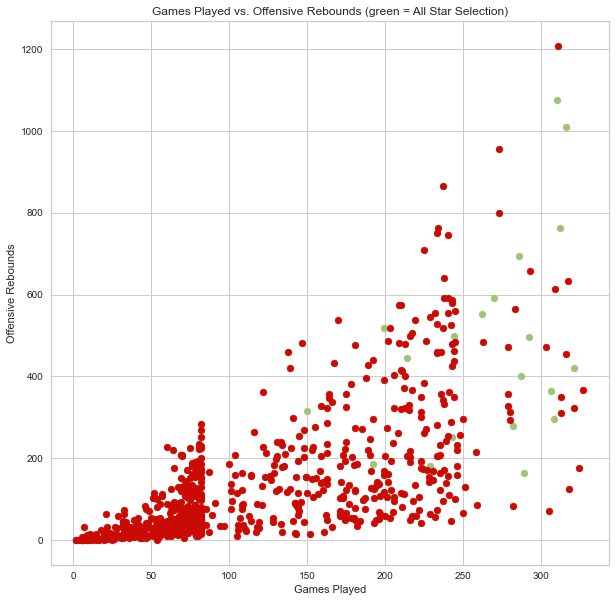

In [19]:
# Scatter-plots:
plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(nrows=1, ncols=1)

all_star_selections = df_test[df_test['ALL_STAR_SELECTION_FLAG_y'] == 1]
all_star_selections = all_star_selections.reset_index(drop=True)

non_all_star_select = df_test[df_test['ALL_STAR_SELECTION_FLAG_y'] == 0]
non_all_star_select = non_all_star_select.reset_index(drop=True)

ax.scatter(all_star_selections.GP, all_star_selections.OREB, c='g')
ax.scatter(non_all_star_select.GP, non_all_star_select.OREB, c='r')
ax.set_xlabel('Games Played')
ax.set_ylabel('Offensive Rebounds')
ax.set_title('Games Played vs. Offensive Rebounds (green = All Star Selection)')

plt.savefig('.\plots\\sp1.png')
plt.show()


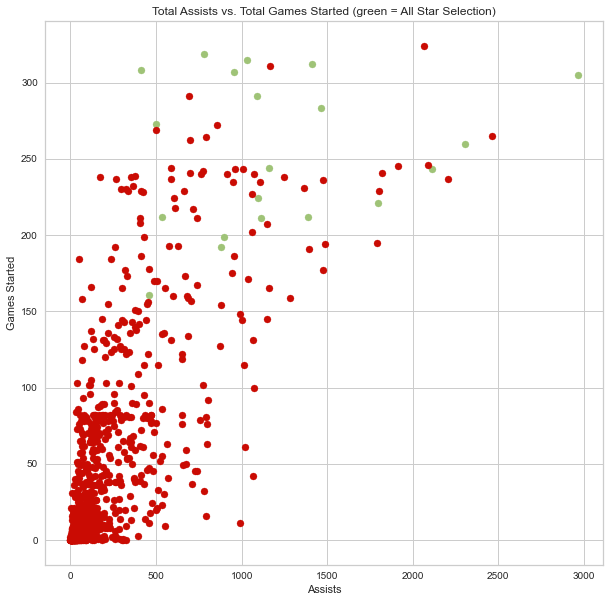

In [20]:
# Scatter-plots:
plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(all_star_selections.AST, all_star_selections.GS, c='g')
ax.scatter(non_all_star_select.AST, non_all_star_select.GS, c='r')
ax.set_xlabel('Assists')
ax.set_ylabel('Games Started')
ax.set_title('Total Assists vs. Total Games Started (green = All Star Selection)')

plt.savefig('.\plots\\sp2.png')
plt.show()


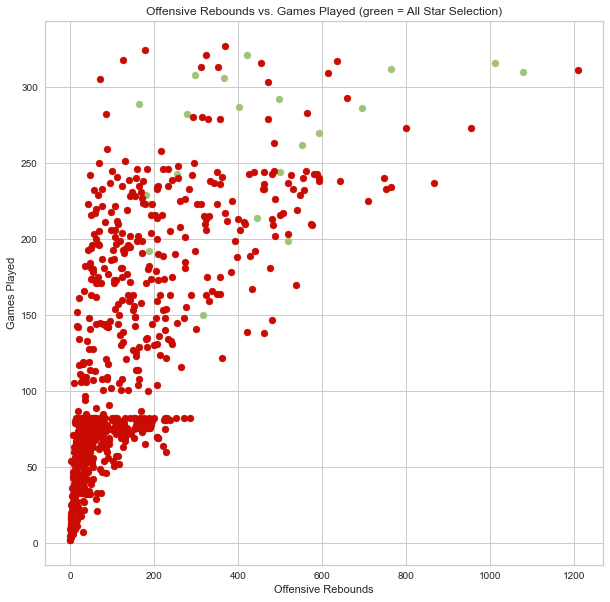

In [21]:
# Scatter-plots
plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(all_star_selections.OREB, all_star_selections.GP, c='g')
ax.scatter(non_all_star_select.OREB, non_all_star_select.GP, c='r')
ax.set_xlabel('Offensive Rebounds')
ax.set_ylabel('Games Played')
ax.set_title('Offensive Rebounds vs. Games Played (green = All Star Selection)')

plt.savefig('.\plots\\sp3.png')
plt.show()


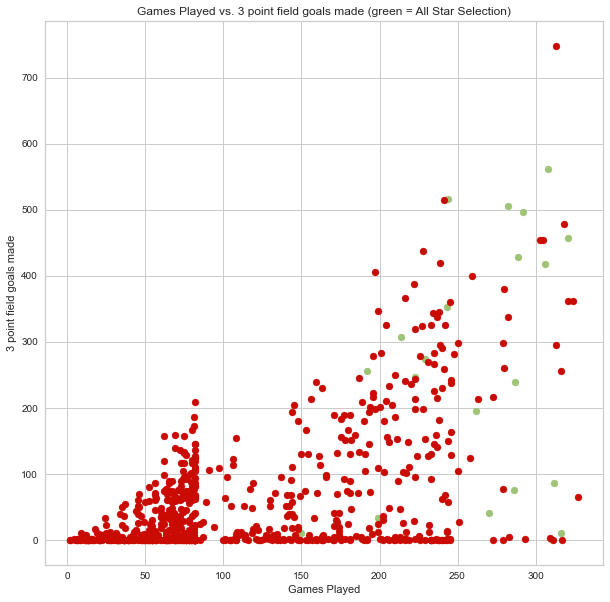

In [22]:
# Scatter-plots
plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(all_star_selections.GP, all_star_selections.FG3M, c='g')
ax.scatter(non_all_star_select.GP, non_all_star_select.FG3M, c='r')
ax.set_xlabel('Games Played')
ax.set_ylabel('3 point field goals made')
ax.set_title('Games Played vs. 3 point field goals made (green = All Star Selection)')

plt.savefig('.\plots\\sp4.png')
plt.show()


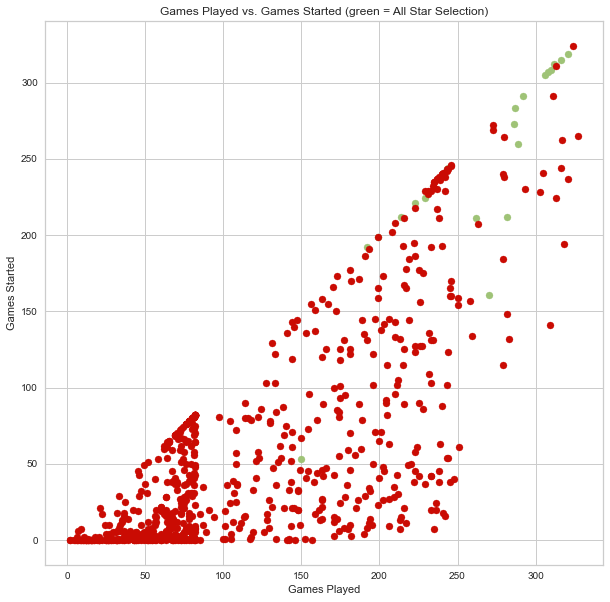

In [23]:
# Scatter-plots
plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(all_star_selections.GP, all_star_selections.GS, c='g')
ax.scatter(non_all_star_select.GP, non_all_star_select.GS, c='r')
ax.set_xlabel('Games Played')
ax.set_ylabel('Games Started')
ax.set_title('Games Played vs. Games Started (green = All Star Selection)')

plt.savefig('.\plots\\sp5.png')
plt.show()

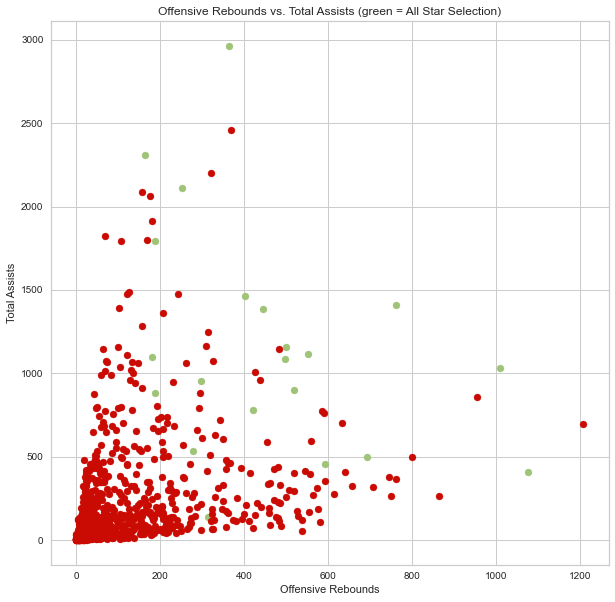

In [24]:
# Scatter-plots
plt.rcParams['figure.figsize'] = (10,10)
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(all_star_selections.OREB, all_star_selections.AST, c='g')
ax.scatter(non_all_star_select.OREB, non_all_star_select.AST, c='r')
ax.set_xlabel('Offensive Rebounds')
ax.set_ylabel('Total Assists')
ax.set_title('Offensive Rebounds vs. Total Assists (green = All Star Selection)')

plt.savefig('.\plots\\sp6.png')
plt.show()

In [25]:
y = df_test['ALL_STAR_SELECTION_FLAG_y']
X = df_test.drop(columns='ALL_STAR_SELECTION_FLAG_y')

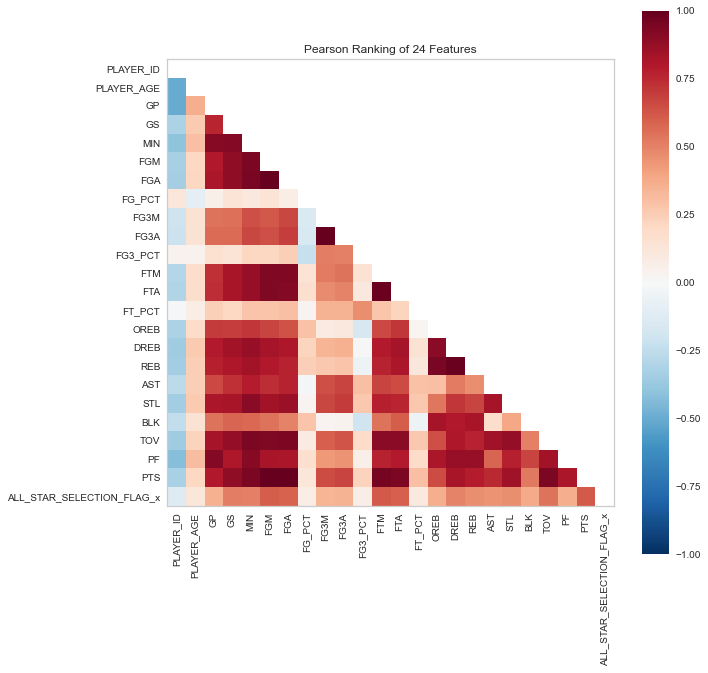

In [26]:
# See what variables are highly correlative and remove them before training the model.

plt.rcParams['figure.figsize'] = (10, 10)

num_features = ['PLAYER_ID', 'PLAYER_AGE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
                'ALL_STAR_SELECTION_FLAG_x']

x = X[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(x)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof(outpath=".\plots\\pcoords1.png") # Draw/show/poof the data
plt.show()

In [27]:
correlated_features = set()
correlation_matrix = df_test.corr()

In [28]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

len(correlated_features)

13

In [29]:
correlated_features

{'BLK',
 'DREB',
 'FG3A',
 'FGA',
 'FGM',
 'FTA',
 'FTM',
 'MIN',
 'PF',
 'PTS',
 'REB',
 'STL',
 'TOV'}

In [30]:
X.drop(labels=correlated_features, axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

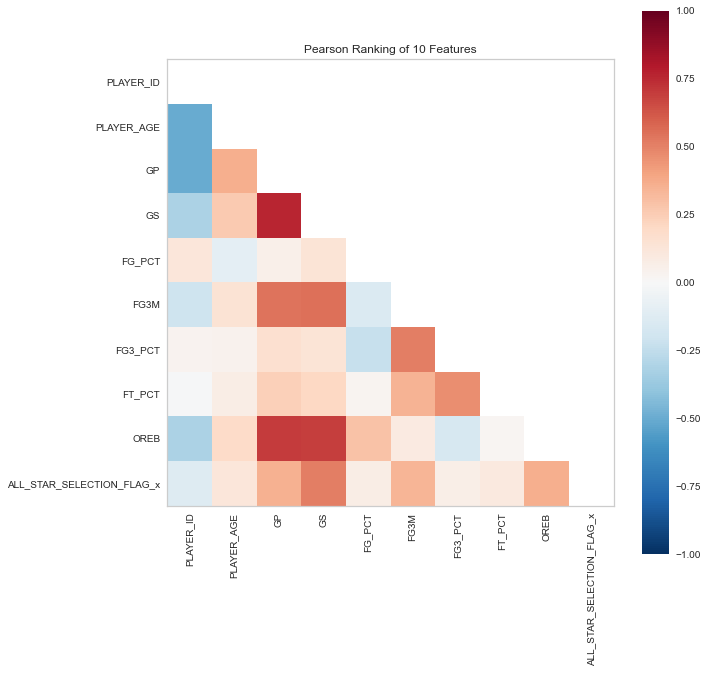

In [31]:
plt.rcParams['figure.figsize'] = (10, 10)

# num_features = ['PLAYER_ID', 'PLAYER_AGE', 'GP', 'GS', 'FG_PCT', 'FG3M', 'FG3_PCT',
#                 'FT_PCT', 'OREB', 'AST', 'ALL_STAR_SELECTION_FLAG_x']
num_features = ['PLAYER_ID', 'PLAYER_AGE', 'GP', 'GS', 'FG_PCT', 'FG3M', 'FG3_PCT',
                'FT_PCT', 'OREB', 'ALL_STAR_SELECTION_FLAG_x']

x = X[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(x)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof(outpath=".\plots\\pcoords2.png") # Draw/show/poof the data
# visualizer.poof() # Draw/show/poof the data
plt.show()

In [32]:
svc = SVC(kernel='sigmoid')
svc.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [33]:
y_pred = svc.predict(X_test)

SVC (sigmoid) Accuracy score:  0.958904109589041
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       210
           1       0.00      0.00      0.00         9

    accuracy                           0.96       219
   macro avg       0.48      0.50      0.49       219
weighted avg       0.92      0.96      0.94       219



C:\Users\ramse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ramse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ramse\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

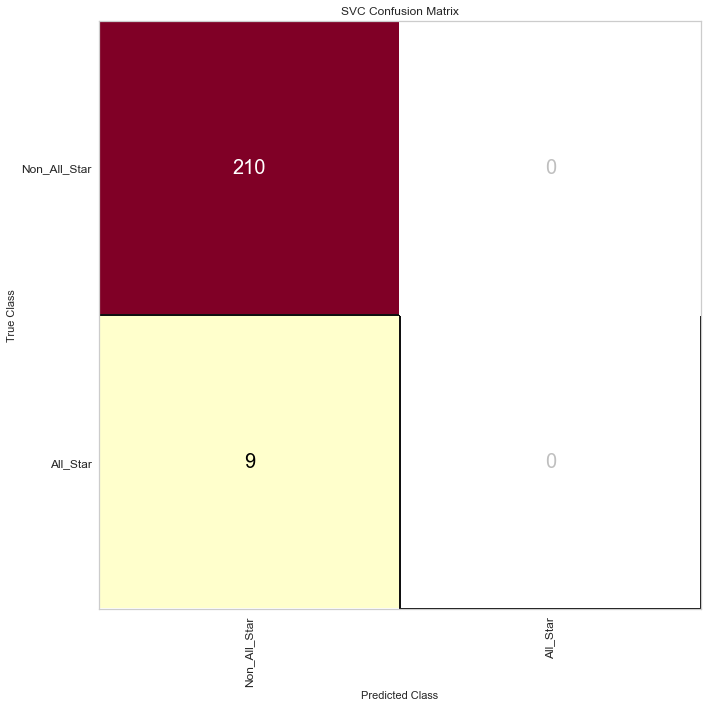

In [34]:
print("SVC (sigmoid) Accuracy score: ",svc.score(X_test, y_test))
print(classification_report(y_test,y_pred))

cm = ConfusionMatrix(svc, classes=['Non_All_Star', 'All_Star'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

cm.poof(outpath='.\plots\\cm1.png')

In [35]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [36]:
y_pred = nb.predict(X_test)

Naive Bayes Accuracy score:  0.867579908675799
              precision    recall  f1-score   support

           0       1.00      0.86      0.93       210
           1       0.24      1.00      0.38         9

    accuracy                           0.87       219
   macro avg       0.62      0.93      0.65       219
weighted avg       0.97      0.87      0.90       219



<AxesSubplot:title={'center':'GaussianNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

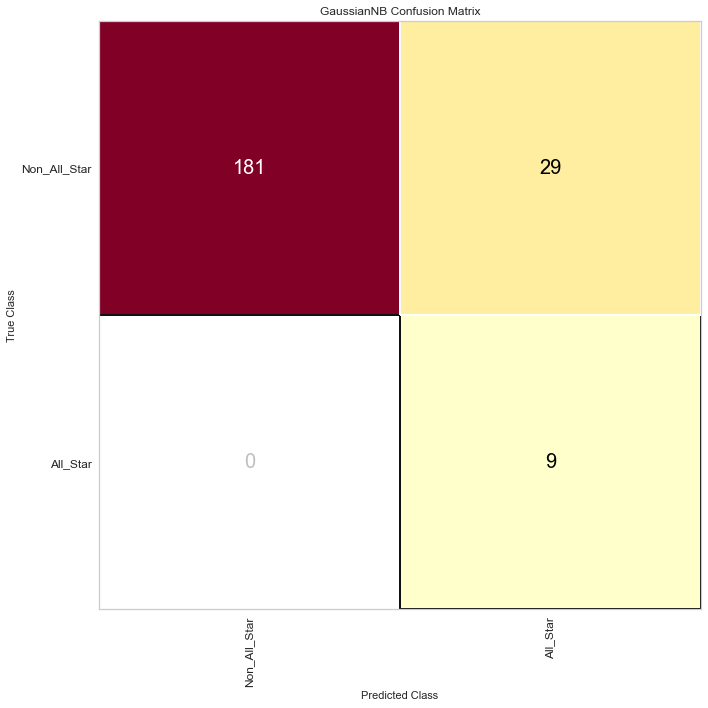

In [37]:
print("Naive Bayes Accuracy score: ",nb.score(X_test, y_test))
print(classification_report(y_test,y_pred))

cm = ConfusionMatrix(nb, classes=['Non_All_Star', 'All_Star'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

cm.poof(outpath='.\plots\\cm2.png')

In [38]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
y_pred = knn.predict(X_test)

KNeighbors Accuracy score:  0.9634703196347032
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       210
           1       0.67      0.22      0.33         9

    accuracy                           0.96       219
   macro avg       0.82      0.61      0.66       219
weighted avg       0.96      0.96      0.95       219



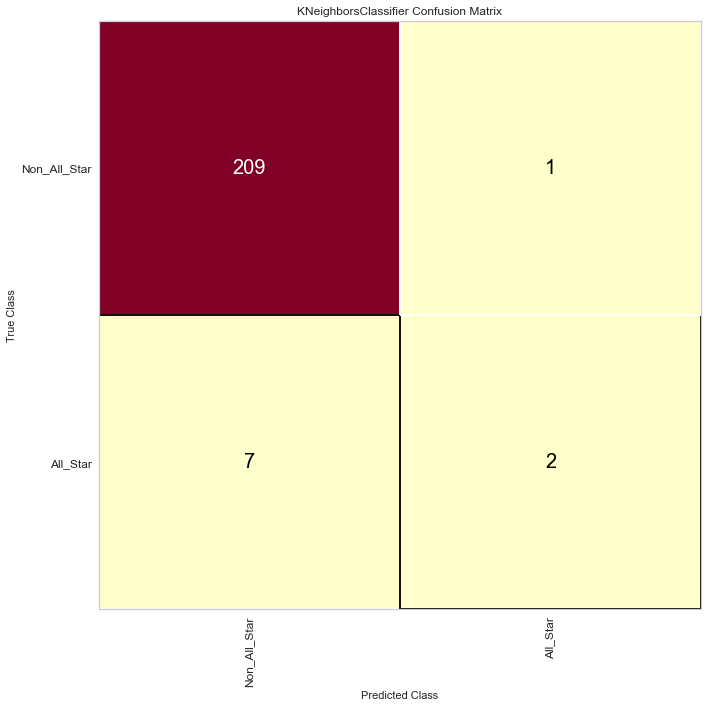

In [40]:

cm = ConfusionMatrix(knn, classes=['Non_All_Star', 'All_Star'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

cm.poof(outpath='.\plots\\cm3.png')
print("KNeighbors Accuracy score: ",knn.score(X_test, y_test))
print(classification_report(y_test, y_pred))

In [41]:
rfc = RandomForestClassifier(n_estimators=5)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5)

In [42]:
y_pred = rfc.predict(X_test)

Random Forest Accuracy score:  0.958904109589041
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       210
           1       0.50      0.22      0.31         9

    accuracy                           0.96       219
   macro avg       0.73      0.61      0.64       219
weighted avg       0.95      0.96      0.95       219



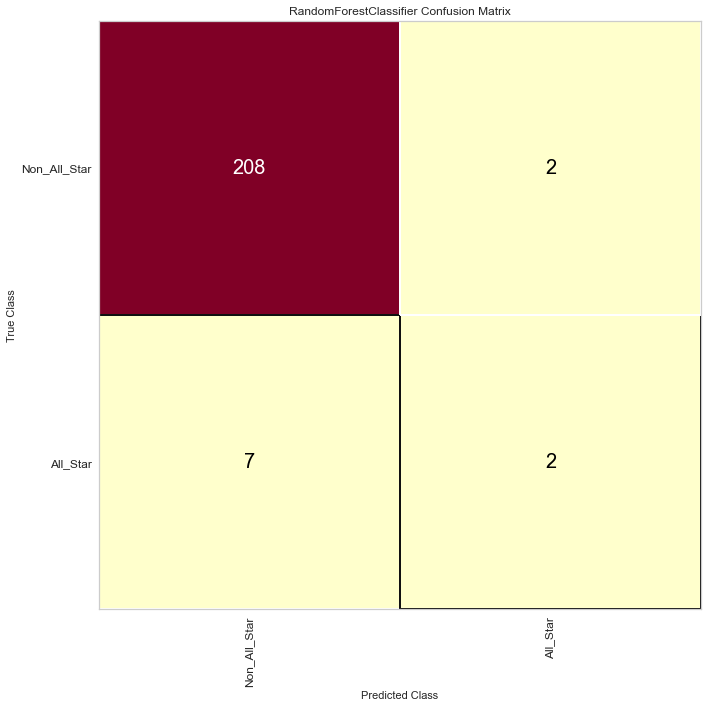

In [43]:
cm = ConfusionMatrix(rfc, classes=['Non_All_Star', 'All_Star'])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

# change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

cm.poof(outpath='.\plots\\cm4.png')
print("Random Forest Accuracy score: ",rfc.score(X_test, y_test))
print(classification_report(y_test, y_pred))

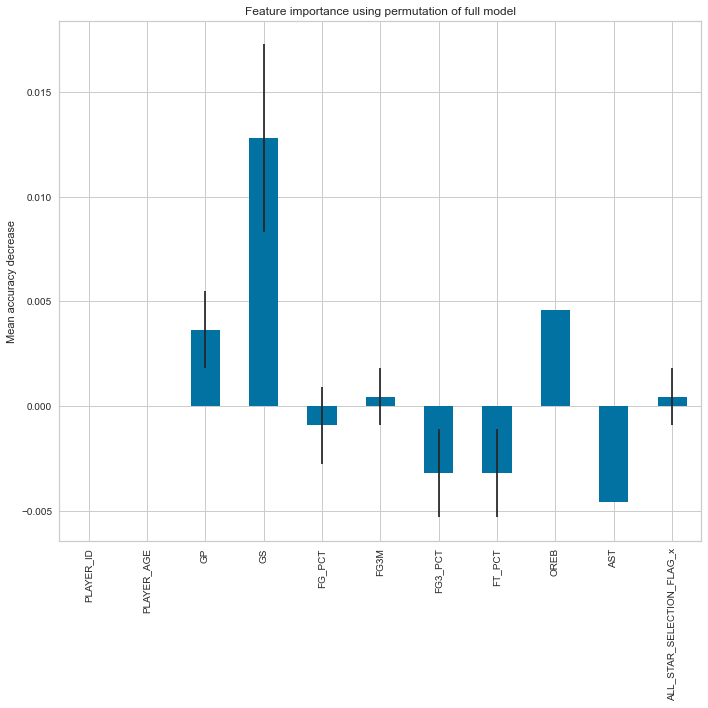

In [44]:
importance = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importance = pd.Series(result.importances_mean, index=X.columns)
fig, ax = plt.subplots()
forest_importance.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importance using permutation of full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

plt.savefig('.\plots\\fi1.png')
plt.show()